In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pandas as pd
import numpy as np
from helpers import (
    load_data,
    EMG_CHANNELS,
    EMG_HP_CHANNELS,
    GYRO_CHANNELS,
    ACC_CHANNELS,
    IMU_CHANNELS,
)
import itertools
from feature_extraction import (
    FeatureExtractor,
    process_dataframe,
    zero_crossings,
    mean_crossings,
    spectral_entropy
)
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# Get only standing samples
standing_data = dataset.loc[:1]



In [63]:
# Define feature extractors for each sensor

segment_length = 200
interval = 50

extractors = {}
extractors.update(
    {
        channel: [
            FeatureExtractor("mean_xing", mean_crossings),
        ]
        for channel in EMG_CHANNELS
    }
)


extractors.update(
    {
        channel: [
            FeatureExtractor("mean", np.mean, segment_length=segment_length, interval=interval),
            FeatureExtractor("var", np.var, segment_length=segment_length, interval=interval),
            FeatureExtractor("mean_xing", peak_frequency, segment_length=segment_length, interval=interval),
            FeatureExtractor("rmean", lambda x: np.mean(np.abs(x))),
            FeatureExtractor("spec_entropy", spectral_entropy(256, 64))
            
        ]
        for channel in EMG_HP_CHANNELS
    }
)

extractors.update(
    {
        channel: [
            FeatureExtractor("mean", np.mean, segment_length=segment_length, interval=interval),
            FeatureExtractor("var", np.var, segment_length=segment_length, interval=interval),
            FeatureExtractor("mean_xing", mean_crossings),
            FeatureExtractor("rmean", lambda x: np.mean(np.abs(x))),
            FeatureExtractor('max_pk_pk', lambda x: np.max(x) - np.min(x))

        ]
        for channel in IMU_CHANNELS
    }
)

extractors.update(
    {
        channel: [
            FeatureExtractor("mean", np.mean, segment_length=segment_length, interval=interval),
            FeatureExtractor("var", np.var, segment_length=segment_length, interval=interval),
            FeatureExtractor("mean_xing", mean_crossings),
            FeatureExtractor("rmean", lambda x: np.mean(np.abs(x))),
            FeatureExtractor('max_pk_pk', lambda x: np.max(x) - np.min(x))

      ]
        for channel in GYRO_CHANNELS
    }
)

extractors.update(
    {
        channel: [
            FeatureExtractor("mean", np.mean, segment_length=segment_length, interval=interval),
            FeatureExtractor("var", np.var, segment_length=segment_length, interval=interval),
            FeatureExtractor("min", np.min),
            FeatureExtractor("max", np.max),
            FeatureExtractor("mean_xing", mean_crossings),
            FeatureExtractor("rmean", lambda x: np.mean(np.abs(x))),
            FeatureExtractor('max_pk_pk', lambda x: np.max(x) - np.min(x))
        ]
        for channel in ACC_CHANNELS
    }
)

# Mixed channel features
extractors.update(
    {
        q_pair: [
            FeatureExtractor("corr", lambda x: np.corrcoef(x.T)[0,1])
        ] for q_pair in itertools.combinations(IMU_CHANNELS, 2)
    }
)
extractors.update(
    {
        q_pair: [
            FeatureExtractor("corr", lambda x: np.corrcoef(x.T)[0,1])
        ] for q_pair in itertools.combinations(GYRO_CHANNELS, 2)
    }
)
extractors.update(
    {
        q_pair: [
            FeatureExtractor("corr", lambda x: np.corrcoef(x.T)[0,1])
        ] for q_pair in itertools.combinations(ACC_CHANNELS, 2)
    }
)

In [64]:
results = process_dataframe(standing_data, extractors)
results

c.h.0.mean_xing  c.h.1.mean_xing  c.h.0._.h.p.mean.0.200  \
body_label rep                                                             
0.0        1.0         0.366388         0.467705                0.963107   
           2.0        -0.449486        -1.156955               -0.415544   
           3.0        -0.698781        -0.381549               -0.522283   
1.0        1.0         1.862158         1.723124               -0.773604   
           2.0        -0.290844        -0.086156               -0.798124   
           3.0        -0.789434        -0.566169                1.546448   

                c.h.0._.h.p.mean.50.250  c.h.0._.h.p.mean.100.300  \
body_label rep                                                      
0.0        1.0                 1.408142                  0.909050   
           2.0                -1.153260                 -1.172221   
           3.0                 0.756559                  0.148957   
1.0        1.0                -0.908280                 -0.120305   
           2.0                -0.428710                 -1.052220   
           3.0                 0.325549                  1.286739   

                c.h.0._.h.p.mean.150.350  c.h.0._.h.p.mean.200.400  \
body_label rep                                                       
0.0        1.0                  0.055744                 -0.728375   
           2.0                 -0.697915                 -0.894154   
           3.0                  1.950536                  0.168044   
1.0        1.0                 -0.139650                 -0.914284   
           2.0                 -0.621546                  1.195990   
           3.0                 -0.547170                  1.172780   

                c.h.0._.h.p.mean.250.450  c.h.0._.h.p.mean.300.500  \
body_label rep                                                       
0.0        1.0                  0.810225                  0.315160   
           2.0                 -0.938028                 -1.362961   
           3.0                 -0.916040                 -0.097949   
1.0        1.0                  1.244559                 -0.454700   
           2.0                  0.626084                  1.679414   
           3.0                 -0.826802                 -0.078964   

                c.h.0._.h.p.mean.350.550  ...  qx.qw.corr  qy.qz.corr  \
body_label rep                            ...                           
0.0        1.0                  1.178998  ...    0.549188    0.608564   
           2.0                 -0.371682  ...   -0.946443   -1.119447   
           3.0                 -1.655716  ...    1.065168    0.662048   
1.0        1.0                 -0.284863  ...   -0.782424    0.633696   
           2.0                  0.506911  ...   -0.954997   -1.448036   
           3.0                  0.626352  ...    1.069508    0.663175   

                qy.qw.corr  qz.qw.corr  gx.gy.corr  gx.gz.corr  gy.gz.corr  \
body_label rep                                                               
0.0        1.0   -1.725373   -0.490515   -0.026443   -0.525951   -1.052279   
           2.0   -0.076398   -1.131230   -0.538276   -0.752258   -0.476463   
           3.0   -0.258338    0.375107    0.926216    1.492209    1.224101   
1.0        1.0    1.269494    1.413017    0.268131   -0.443543   -1.089805   
           2.0    0.510111   -0.898221   -1.653017   -0.809274    0.636588   
           3.0    0.280504    0.731842    1.023389    1.038818    0.757858   

                ax.ay.corr  ax.az.corr  ay.az.corr  
body_label rep                                      
0.0        1.0    0.154050    0.704554   -0.509089  
           2.0    1.230076    0.736440   -0.655779  
           3.0   -1.110242   -1.341903    1.203431  
1.0        1.0   -0.063723    0.060088   -0.701455  
           2.0    0.944777    0.955851   -0.705565  
           3.0   -1.154938   -1.115031    1.368457  

[6 rows x 478 columns]

<IPython.core.display.Javascript object>


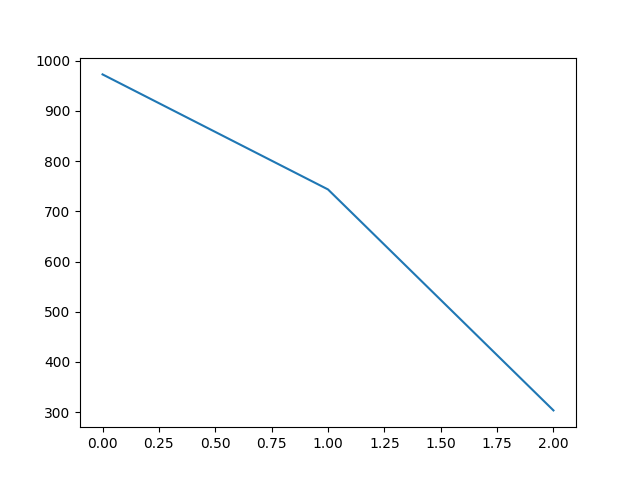

<IPython.core.display.Javascript object>


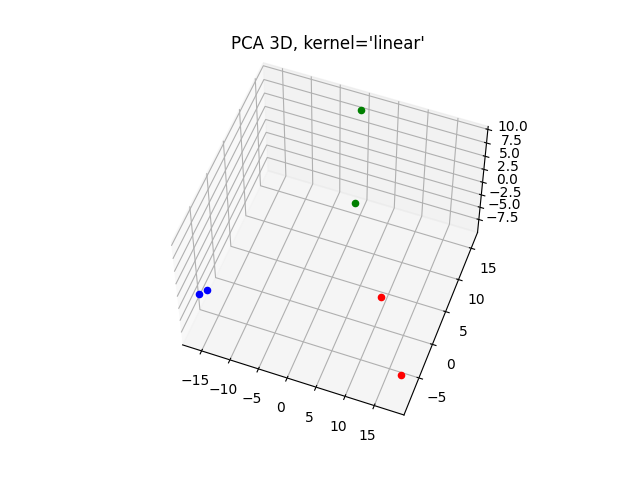

<IPython.core.display.Javascript object>


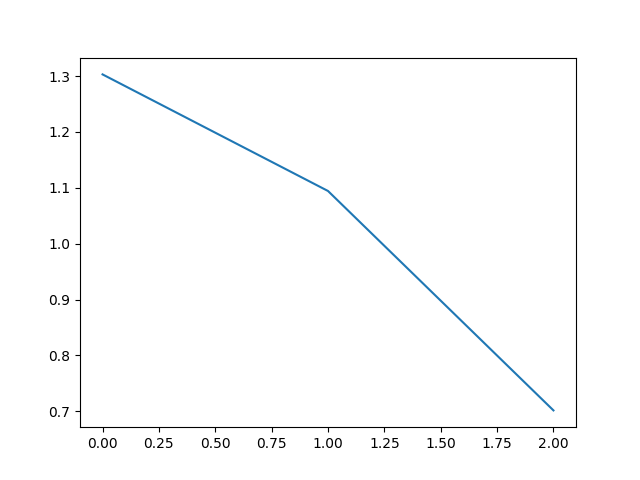

<IPython.core.display.Javascript object>


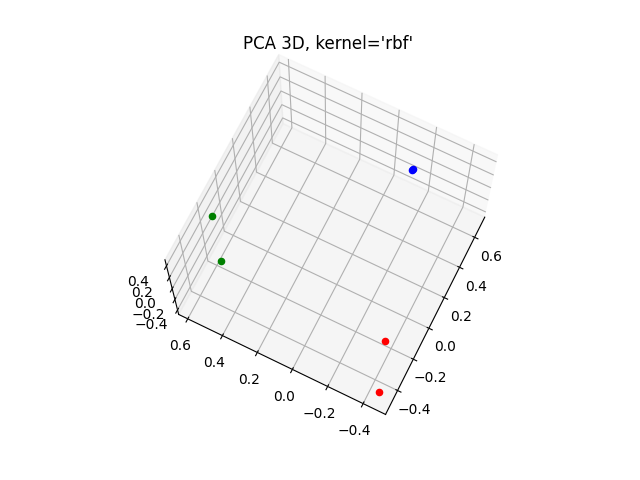

<IPython.core.display.Javascript object>


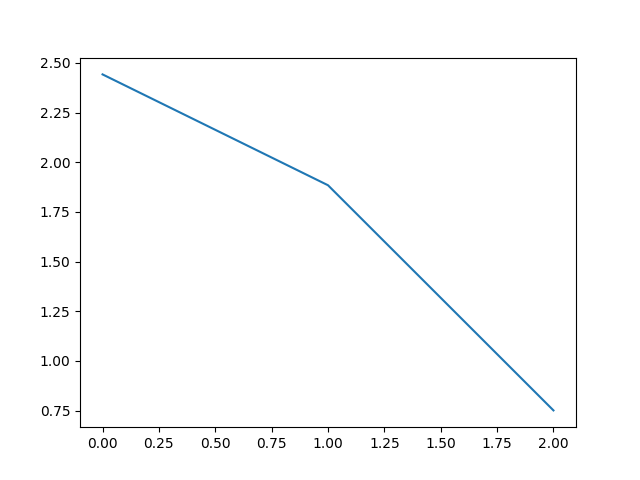

<IPython.core.display.Javascript object>


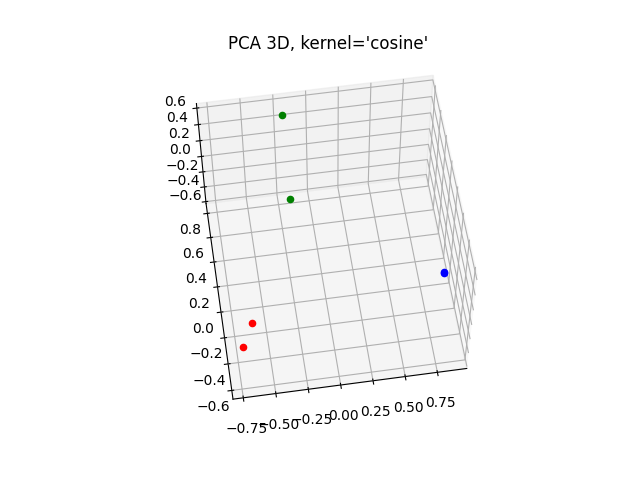

In [65]:

color_map = {0: 'g', 1: 'b', 2: 'r'}

results.index.get_level_values(1)


for kernel in ['linear', 'rbf', 'cosine']:
    pca = KernelPCA(n_components=3, kernel=kernel)
    pca.fit(results)
    output = pca.transform(results)
    fig = plt.figure()
    plt.plot(pca.eigenvalues_)
    plt.show()
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for rep in range(len(output)):
        ax.scatter(output[rep, 0], output[rep, 1], output[rep, 2], color=color_map[rep % 3])
    plt.title(f'PCA 3D, {kernel=}')
    plt.show()
